In [1]:
import networkx as nx
import pyfastx as fx
from tqdm import tqdm
import numpy as np
import pandas as pd
import json
import pydot
from copy import deepcopy
from collections import defaultdict
from IPython.display import Image

In [115]:
class DBG:
    
    def __init__(self, path, k):
        self.reads = fx.Fastx(path)
        self.k = k
        self.k_coverage = defaultdict(int)
        self.comp_dict = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
        
        
    def comp_seq(self, seq):
        return ''.join([self.comp_dict[base] for base in seq[::-1]])
    
    
    def create_graph(self):
        graph = nx.DiGraph()
        for read in self.reads:
            seq = read[1]
            for i in range(len(seq)-self.k):
                
                #добавление пары k-меров в общий граф
                node_1 = seq[i:i+self.k]
                node_2 = seq[i+1:i+1+self.k]
                self.k_coverage[node_1] += 1
                graph.add_edge(node_1, node_2)
                
                #добавление пары комплементарных k-меров в общий граф
                comp_node_1 = self.comp_seq(node_2)
                comp_node_2 = self.comp_seq(node_1)
                self.k_coverage[comp_node_2] += 1
                graph.add_edge(comp_node_1, comp_node_2)
            
            #учёт последних k-меров
            self.k_coverage[node_2] += 1
            self.k_coverage[comp_node_1] += 1
        
        self.matrix = nx.convert_matrix.to_pandas_adjacency(graph)
        #return self.matrix
    
    def create_edges(self):
        self.edges = pd.DataFrame(columns=['n_1', 'n_2', 'edge'])
        kmers = self.matrix.columns
        edges_ind = np.where(self.matrix == 1)
        for count, (ind_1, ind_2) in enumerate(zip(edges_ind[0], edges_ind[1])):
            self.edges.loc[count] = [kmers[ind_1], kmers[ind_2], kmers[ind_1] + kmers[ind_2][-1]]
        #return self.edges
    
    
    def compress_graph(self):
        n_edges = self.edges.shape[0]
        while True:
            for node in self.matrix.columns:
                n_in = np.sum(self.matrix.loc[:, node])
                n_out = np.sum(self.matrix.loc[node, :])
                if n_in == n_out == 1:
                    node_in = self.matrix.columns[np.argmax(self.matrix.loc[:, node])]
                    node_out = self.matrix.columns[np.argmax(self.matrix.loc[node, :])]
                    self.matrix.drop(node, axis=0, inplace=True)
                    self.matrix.drop(node, axis=1, inplace=True)
                    self.matrix.loc[node_in, node_out] += 1
                    in_edge = self.edges[(self.edges['n_1'] == node_in) & ((self.edges['n_2'] == node))]['edge'].values[0]
                    out_edge = self.edges[(self.edges['n_1'] == node) & ((self.edges['n_2'] == node_out))]['edge'].values[0]
                    new_edge = in_edge[:-self.k] + out_edge
                    self.edges = self.edges[(self.edges['edge'] != in_edge) & (self.edges['edge'] != out_edge)]
                    self.edges.reset_index(drop=True, inplace=True)
                    self.edges.loc[self.edges.shape[0]] = [node_in, node_out, new_edge]
                    break
                else:
                    continue
            if n_edges != self.edges.shape[0]:
                n_edges = self.edges.shape[0]
            else:
                break
        #return self.matrix, self.edges
    
    
    def mean_cov(self, edge):
        return np.mean([self.k_coverage[edge[i:i+self.k]] for i in range(len(edge)+1-self.k)])
        
        
        
        
    def add_meta_data(self):
        self.edges['L'] = self.edges['edge'].apply(len)
        self.edges['cov'] = self.edges['edge'].apply(lambda edge: self.mean_cov(edge))
        #return self.edges
    
    
    def discard_tips(self, min_cov, min_len):
        for node in self.matrix.columns:
            n_in = np.sum(self.matrix.loc[:, node])
            n_out = np.sum(self.matrix.loc[node, :])
            if n_in + n_out == 1:
                edge = self.edges[(self.edges['n_1'] == node) | (self.edges['n_2'] == node)]
                if edge['L'].values[0] < min_len or edge['cov'].values[0] < min_cov:
                    self.matrix.drop(node, axis=0, inplace=True)
                    self.matrix.drop(node, axis=1, inplace=True)
                    self.edges = self.edges[~((self.edges['n_1'] == node) | (self.edges['n_2'] == node))]
                    self.edges.reset_index(drop=True, inplace=True)
        #return self.matrix, self.edges

    
    def discard_all_bad(self, min_cov, min_len):
        n_edges = self.edges.shape[0]
        while True:
            for i, edge in self.edges.iterrows():   
                if edge['L'] < min_len or edge['cov'] < min_cov:
                    self.matrix.loc[edge['n_1'], edge['n_2']] -= 1
                    self.edges.drop(index=i, inplace=True)
                    self.edges.reset_index(drop=True, inplace=True)
                    break
                else:
                    continue
            if n_edges != self.edges.shape[0]:
                n_edges = self.edges.shape[0]
            else:
                break
        #return self.matrix, self.edges
    
    
    def write_in_dot(self, dot_file_path, nodes_file_path):
        with open(dot_file_path, "w") as dot_file:
            dot_file.write("digraph {\n")
            nodes = set(self.edges['n_1'].values) | set(self.edges['n_2'].values)
            node_id = {node: i for i, node in enumerate(nodes)}
            json.dump(dict(enumerate(nodes)), open(nodes_file_path, "w"))
            for node in nodes:
                dot_file.write(f"{node_id[node]};\n")
            for i, (n_1, n_2) in enumerate(zip(self.edges['n_1'], self.edges['n_2'])):
                label = f" L:{self.edges['L'][i]}\n cov:{self.edges['cov'][i]:.1f}"
                dot_file.write(f"""{node_id[n_1]} -> {node_id[n_2]} [label="{label}"];\n""") 
            dot_file.write("}")


    def dot_to_png(self, dot_file_path, png_file_path):
        (graph,) = pydot.graph_from_dot_file(dot_file_path)
        graph.write_png(png_file_path)


    def edges_to_fasta(self, fasta_file_path):
        with open(fasta_file_path, "w") as fasta_file:
            for i, row in self.edges.iterrows():
                title = f"> {row['n_1']} -> {row['n_2']} | Len:{row['L']};Cov:{row['cov']:.1f}"
                seq = row['edge']
                fasta_file.write(f"{title}\n{seq}\n")

# test1

In [86]:
test1_reads_path = 'test1.fasta'
test_1_dot_path = 'test1.dot'
test_1_nodes_path = 'test1.json'
test_1_png_path = 'test1.png'
test_1_edges_fasta_path = 'test1_edges.fasta'

test1_DBG = DBG(test1_reads_path, 55)
test1_DBG.create_graph()
test1_DBG.create_edges()
test1_DBG.compress_graph()
test1_DBG.add_meta_data()
test1_DBG.write_in_dot(test_1_dot_path, test_1_nodes_path)
test1_DBG.dot_to_png(test_1_dot_path, test_1_png_path)
test1_DBG.edges_to_fasta(test_1_edges_fasta_path)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


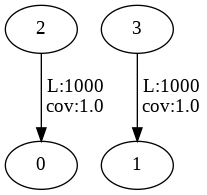

In [87]:
Image('test1.png')

# test2

In [89]:
test2_reads_path =  'test2.fasta'
test_2_dot_path = 'test2.dot'
test_2_nodes_path = 'test2.json'
test_2_png_path = 'test2.png'
test_2_edges_fasta_path = 'test2_edges.fasta'

test2_DBG = DBG(test2_reads_path, 55)
test2_DBG.create_graph()
test2_DBG.create_edges()
test2_DBG.compress_graph()
test2_DBG.add_meta_data()
test2_DBG.write_in_dot(test_2_dot_path, test_2_nodes_path)
test2_DBG.dot_to_png(test_2_dot_path, test_2_png_path)
test2_DBG.edges_to_fasta(test_2_edges_fasta_path)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


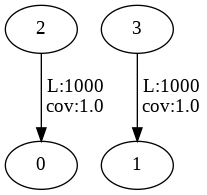

In [90]:
Image('test2.png')

# Ecoli_single

In [95]:
ecoli_single_reads_path = 'ECOLI_IS220_QUAKE_1K_single_reads.fasta'
ecoli_single_dot_path = 'ecoli_single.dot'
ecoli_single_nodes_path = 'ecoli_single.json'
ecoli_single_png_path = 'ecoli_single.png'
ecoli_single_edges_fasta_path = 'ecoli_single_edges.fasta'

ecoli_single_DBG = DBG(ecoli_single_reads_path, 55)
ecoli_single_DBG.create_graph()
ecoli_single_DBG.create_edges()
ecoli_single_DBG.compress_graph()
ecoli_single_DBG.add_meta_data()
ecoli_single_DBG.write_in_dot(ecoli_single_dot_path, ecoli_single_nodes_path)
ecoli_single_DBG.dot_to_png(ecoli_single_dot_path, ecoli_single_png_path)
ecoli_single_DBG.edges_to_fasta(ecoli_single_edges_fasta_path)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


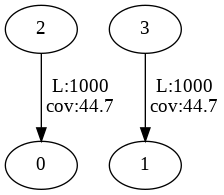

In [98]:
Image('ecoli_single.png')

# Ecoli_paired

In [111]:
ecoli_paired_reads_path = 'ECOLI_IS220_QUAKE_1K_paired_reads.fasta'
ecoli_paired_dot_path = 'ecoli_paired.dot'
ecoli_paired_nodes_path = 'ecoli_paired.json'
ecoli_paired_png_path = 'ecoli_paired.png'
ecoli_paired_edges_fasta_path = 'ecoli_paired_edges.fasta'

ecoli_paired_DBG = DBG(ecoli_paired_reads_path, 55)
ecoli_paired_DBG.create_graph()
ecoli_paired_DBG.create_edges()
ecoli_paired_DBG.compress_graph()
ecoli_paired_DBG.add_meta_data()
ecoli_paired_DBG.write_in_dot(ecoli_paired_dot_path, ecoli_paired_nodes_path)
ecoli_paired_DBG.dot_to_png(ecoli_paired_dot_path, ecoli_paired_png_path)
ecoli_paired_DBG.edges_to_fasta(ecoli_paired_edges_fasta_path)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


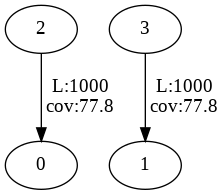

In [112]:
Image('ecoli_paired.png')

# S_6.first1000

In [129]:
s_6_1000_reads_path = 's_6.first1000.fastq.gz'
s_6_1000_dot_path = 's_6_1000.dot'
s_6_1000_nodes_path = 's_6_1000.json'
s_6_1000_png_path = 's_6_1000.png'
s_6_1000_edges_fasta_path = 's_6_1000_edges.fasta'

s_6_1000_DBG = DBG(s_6_1000_reads_path, 55)
s_6_1000_DBG.create_graph()
s_6_1000_DBG.create_edges()
s_6_1000_DBG.compress_graph()
s_6_1000_DBG.add_meta_data()
s_6_1000_DBG.write_in_dot(s_6_1000_dot_path, s_6_1000_nodes_path)
s_6_1000_DBG.dot_to_png(s_6_1000_dot_path, s_6_1000_png_path)
s_6_1000_DBG.edges_to_fasta(s_6_1000_edges_fasta_path)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


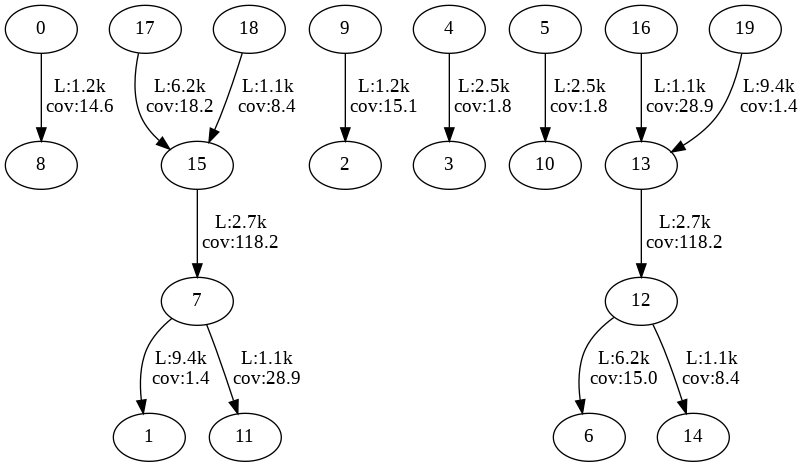

In [2]:
Image('graph_1k.png')

## Отбрасывание хвостиков

In [127]:
min_len = 1
min_cov = 25
s_6_1000_DBG.discard_tips(min_cov, min_len)
s_6_1000_DBG.write_in_dot('s_6_1000_tips.dot', 's_6_1000_tips.json')
s_6_1000_DBG.dot_to_png('s_6_1000_tips.dot', 's_6_1000_tips.png')
s_6_1000_DBG.edges_to_fasta('s_6_1000_tips_edges.fasta')

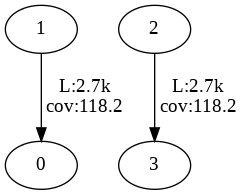

In [4]:
Image('graph_1k_tips.png')

## Отбрасывание всех плохих рёбер

In [130]:
min_len = 1
min_cov = 25
s_6_1000_DBG.discard_all_bad(min_cov, min_len)
s_6_1000_DBG.write_in_dot('s_6_1000_allbad.dot', 's_6_1000_allbad.json')
s_6_1000_DBG.dot_to_png('s_6_1000_allbad.dot', 's_6_1000_allbad.png')
s_6_1000_DBG.edges_to_fasta('s_6_1000_allbad_edges.fasta')

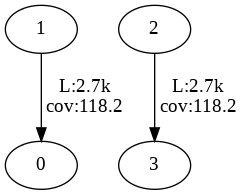

In [5]:
Image('graph_1k_allbad.png')

# S_6.first10000

In [135]:
s_6_10000_reads_path = 's_6.first10000.fastq.gz'
s_6_10000_dot_path = 's_6_10000.dot'
s_6_10000_nodes_path = 's_6_10000.json'
s_6_10000_png_path = 's_6_10000.png'
s_6_10000_edges_fasta_path = 's_6_10000_edges.fasta'

s_6_10000_DBG = DBG(s_6_10000_reads_path, 55)
s_6_10000_DBG.create_graph()
s_6_10000_DBG.create_edges()
s_6_10000_DBG.compress_graph()
s_6_10000_DBG.add_meta_data()
s_6_10000_DBG.write_in_dot(s_6_10000_dot_path, s_6_10000_nodes_path)
s_6_10000_DBG.dot_to_png(s_6_10000_dot_path, s_6_10000_png_path)
s_6_10000_DBG.edges_to_fasta(s_6_10000_edges_fasta_path)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


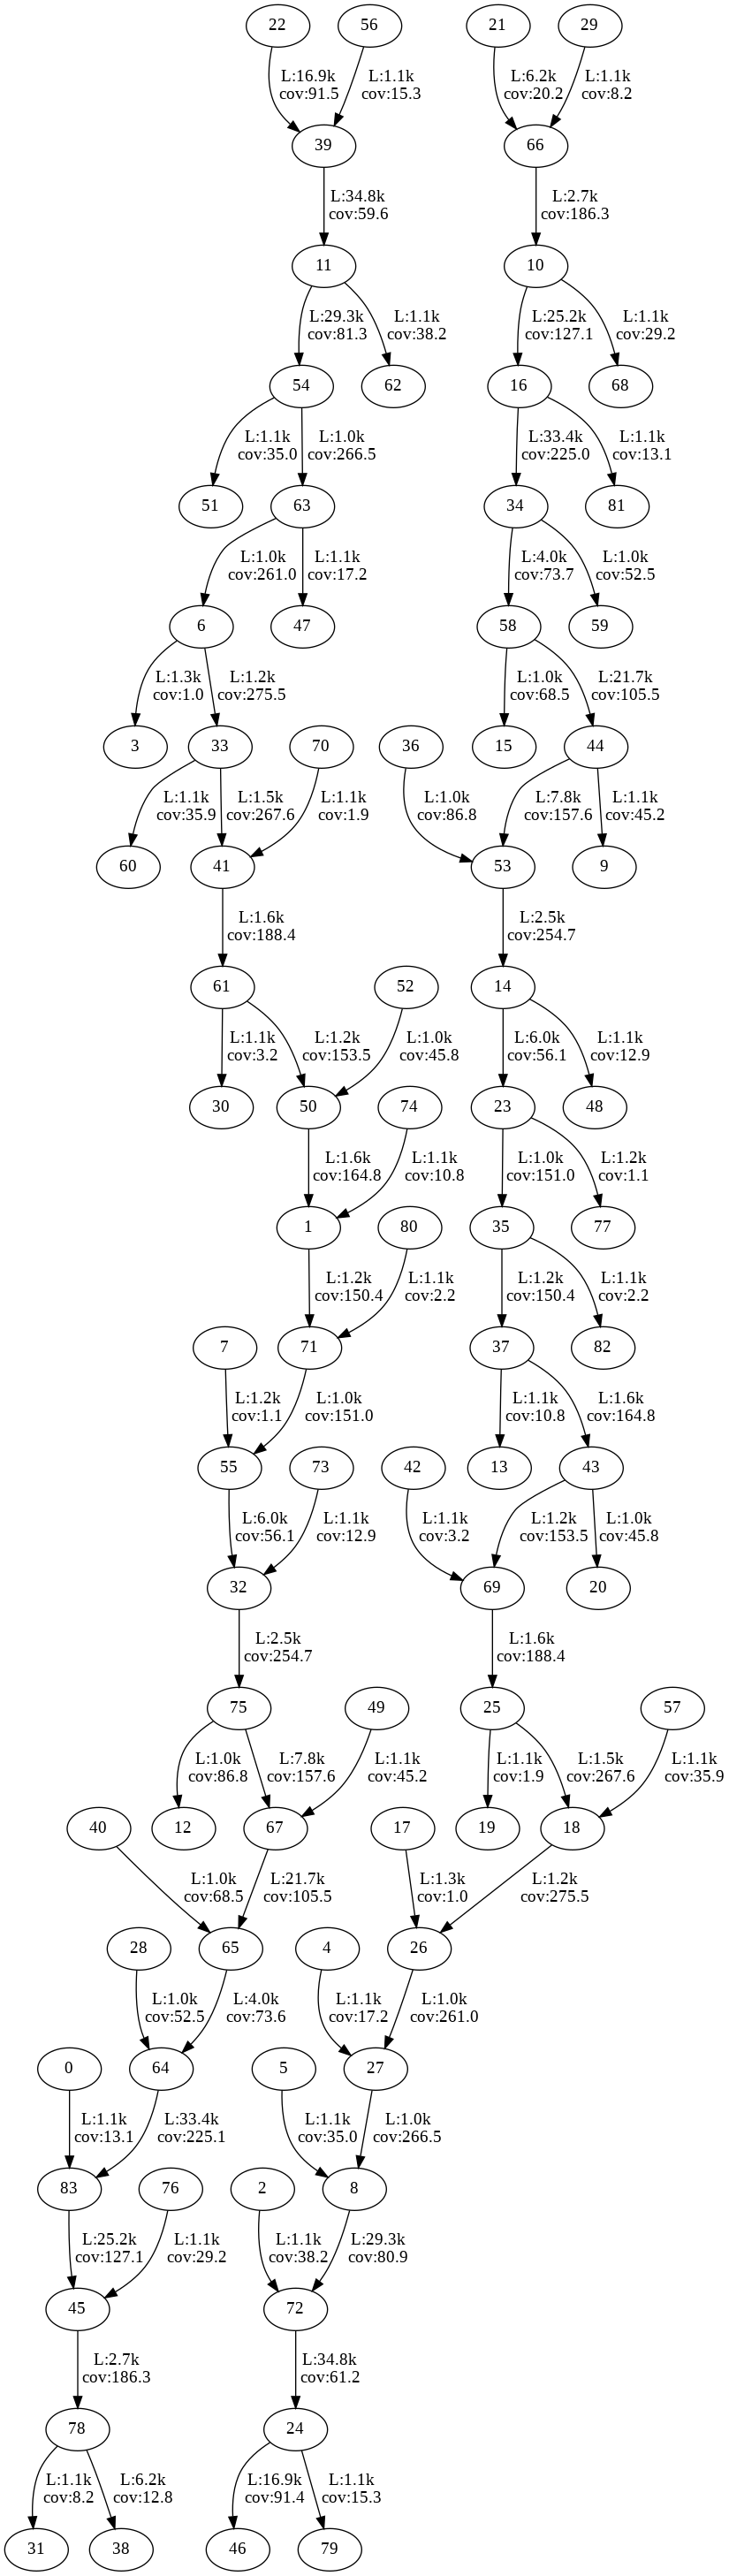

In [6]:
Image('10k.png')

In [147]:
matrix_10k = deepcopy(s_6_10000_DBG.matrix)
edges_10k = deepcopy(s_6_10000_DBG.edges)

## Отбрасывание хвостиков

In [154]:
min_len = 5
min_cov = 50
s_6_10000_DBG.discard_tips(min_cov, min_len)
s_6_10000_DBG.write_in_dot('s_6_10000_tips.dot', 's_6_10000_tips.json')
s_6_10000_DBG.dot_to_png('s_6_10000_tips.dot', 's_6_10000_tips.png')
s_6_10000_DBG.edges_to_fasta('s_6_10000_tips_edges.fasta')

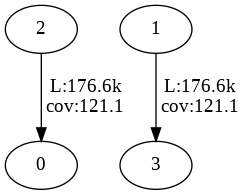

In [7]:
Image('10k_tips_c.png')

## Отбрасывание всех плохих рёбер

In [158]:
s_6_10000_DBG.matrix = matrix_10k
s_6_10000_DBG.edges = edges_10k

In [159]:
min_len = 5
min_cov = 50
s_6_10000_DBG.discard_all_bad(min_cov, min_len)
s_6_10000_DBG.write_in_dot('s_6_10000_allbad.dot', 's_6_10000_allbad.json')
s_6_10000_DBG.dot_to_png('s_6_10000_allbad.dot', 's_6_10000_allbad.png')
s_6_10000_DBG.edges_to_fasta('s_6_10000_allbad_edges.fasta')

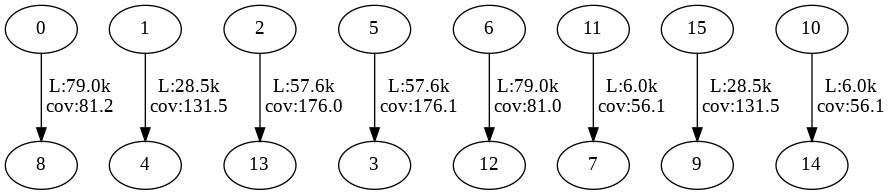

In [8]:
Image('10k_allbad_c.png')

## Выводы:

Для достаточно небольших сжатых графов Де Брюйна(как в тестовых данных и в s_6_1k) оба способа очистки показывают схожие результаты и достаточно просто выбирать пороговые значения покрытия и длины ребра.

Для ридов s_6_10k сжатый граф Де Брюйна куда более сложный, а способы очистки при равных пороговых значениях дают различные результаты. Отбрасывания хвостиков работает более аккуратно, оставляя больше информации(2 компоненты связности, как и в неочищенном графе), в то время как отбрасывание всех плохих рёбер оставило уже 8 компонент.  